# Regression Transformer Model
Predicts the number of comments an article will get based on the article's topic, tone, length, hour of the day and day of the week

In [18]:
import tensorflow as tf
from keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense, Flatten
from keras.datasets import imdb
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [19]:
# Implementation of Transformer encoder from scratch in TensorFlow and Keras
# By Jason Brownlee on February 24, 2021
# Available at https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras/
def encoder_block(embed_dim, num_heads, ff_dim, dropout_rate):
    # initalise all of the layers
    multihead_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    feed_forward = Sequential(
        [Dense(ff_dim, activation="relu"),
         Dense(embed_dim), ]
    )
    add_norm = LayerNormalization(epsilon=1e-6)
    dropout = Dropout(dropout_rate)
    
    # apply the encoder block to input data
    def call(inputs, training):
        attn_output = multihead_attention(inputs, inputs)
        attn_output = dropout(attn_output, training=training)
        out1 = add_norm(inputs + attn_output)
        feedforward_output = feed_forward(out1)
        feedforward_output = dropout(feedforward_output, training=training)
        return add_norm(out1 + feedforward_output)
    
    return call

In [20]:
# Implementation of Transformer decoder from scratch in TensorFlow and Keras
# By Jason Brownlee on February 24, 2021
# Available at https://machinelearningmastery.com/implementing-the-transformer-decoder-from-scratch-in-tensorflow-and-keras/
def decoder_block(num_heads, embed_dim, ff_dim, dropout_rate):
    # initialise the layers
    multihead_attention1 = MultiHeadAttention(num_heads, embed_dim, embed_dim)
    dropout1 = Dropout(dropout_rate)
    add_norm1 = LayerNormalization(epsilon=1e-6)
    
    multihead_attention2 = MultiHeadAttention(num_heads, embed_dim, embed_dim)
    dropout2 = Dropout(dropout_rate)
    add_norm2 = LayerNormalization(epsilon=1e-6)
    
    feed_forward = Sequential(
        [Dense(ff_dim, activation="relu"),
         Dense(embed_dim), ]
    )
    dropout3 = Dropout(dropout_rate)
    add_norm3 = LayerNormalization(epsilon=1e-6)
    
    # apply the decoder block to encoder output
    def call(inputs, encoder_output, training):
        multihead_output1 = multihead_attention1(inputs, inputs, inputs)
        multihead_output1 = dropout1(multihead_output1)
        addnorm_output1 = add_norm1(inputs + multihead_output1)
        multihead_output2 = multihead_attention2(addnorm_output1, encoder_output, encoder_output)
        multihead_output2 = dropout2(multihead_output2)
        addnorm_output2 = add_norm2(addnorm_output1 + multihead_output2)
        feedforward_output = feed_forward(addnorm_output2)
        feedforward_output = dropout3(feedforward_output)

        return add_norm3(addnorm_output2 + feedforward_output)

    return call

In [21]:
#Load training data
train_df = pd.read_csv('../../data/regression_train.csv')

# Extract the columns you want to use as input features
columns = ['BERT_sentiment_score', 'normalised_word_count', 'pub_day', 'pub_hour', 'topic']
# Extract input features from the dataframe
x_train = np.array(train_df[columns])

y_train = np.array(train_df['n_comments'])

In [22]:
# Training and validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [23]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_mae', 
                               # Number of epochs to wait for improvement
                               patience=20,  
                               verbose=1, 
                               # Restore the weights of the best epoch
                               restore_best_weights=True)

In [24]:
# Hypreparameters
max_seq_length = x_train.shape[1]
vocab_size = int(np.max(x_train) + 1)
embedding_dim = 32
num_heads = 2
ff_dim = 32
dropout_rate = 0.1

In [25]:
# Define model architecture

# Input 
inputs = Input(shape=(max_seq_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# Encoder
encoder_block_fn = encoder_block(embed_dim=embedding_dim, 
                                 num_heads=num_heads, 
                                 ff_dim=ff_dim,
                                 dropout_rate=dropout_rate)
encoder_output = encoder_block_fn(embedding_layer, training=True)

# Decoder
decoder_block_fn = decoder_block(num_heads=num_heads,
                                 embed_dim=embedding_dim,
                                 ff_dim=ff_dim,
                                 dropout_rate=dropout_rate)
decoder_output = decoder_block_fn(inputs=encoder_output, 
                                  encoder_output=encoder_output,
                                  training=True)

# Pooling and Dropout
pooling_layer = GlobalAveragePooling1D()(decoder_output)
dropout_layer = Dropout(dropout_rate)(pooling_layer)

# Output
# Change activation to 'linear' for regression
outputs = Dense(units=1, activation='linear')(dropout_layer)  

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 5, 32)        2688        ['input_3[0][0]']                
                                                                                                  
 multi_head_attention_6 (MultiH  (None, 5, 32)       8416        ['embedding_2[0][0]',            
 eadAttention)                                                    'embedding_2[0][0]']            
                                                                                                  
 dropout_10 (Dropout)           (None, 5, 32)        0           ['multi_head_attention_6[0]

In [26]:
# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])  # Change loss function to 'mse' for regression

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), 
          callbacks=[early_stopping])

Epoch 1/100
125/125 [==============================] - 9s 29ms/step - loss: 374303.2812 - mae: 303.4438 - val_loss: 321424.7500 - val_mae: 274.9468
Epoch 2/100
125/125 [==============================] - 3s 20ms/step - loss: 368970.3438 - mae: 297.8683 - val_loss: 315758.9375 - val_mae: 269.4108
Epoch 3/100
125/125 [==============================] - 2s 18ms/step - loss: 361881.2812 - mae: 292.4872 - val_loss: 308461.6875 - val_mae: 264.5452
Epoch 4/100
125/125 [==============================] - 3s 21ms/step - loss: 353104.0312 - mae: 287.9194 - val_loss: 300089.3750 - val_mae: 261.2499
Epoch 5/100
125/125 [==============================] - 3s 24ms/step - loss: 343534.3750 - mae: 284.7967 - val_loss: 291060.9375 - val_mae: 259.1083
Epoch 6/100
125/125 [==============================] - 4s 31ms/step - loss: 332995.0000 - mae: 280.9925 - val_loss: 281412.7812 - val_mae: 254.3499
Epoch 7/100
125/125 [==============================] - 3s 20ms/step - loss: 322235.2812 - mae: 277.0272 - val_lo

In [17]:
# save the trained model
model.save('../transformer_regression_model.h5')

In [114]:
model = load_model('../transformer_regression_model.h5')

In [15]:
# Evaluate the model on validation data
mse, mae = model.evaluate(x_val, y_val)
print('Validation MSE:', mse)
print('Validation MAE:', mae)

63/63 [==============================] - 0s 7ms/step - loss: 172600.3438 - mae: 216.1665
Validation MSE: 172600.34375
Validation MAE: 216.16653442382812


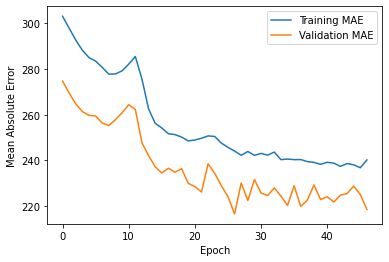

In [16]:
# plot the training and validation loss
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()